<a href="https://colab.research.google.com/github/Dmitri00/adas_sign_detection/blob/master/sign_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!tar xvf rtsd-r1.tar > /dev/null

In [57]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import skimage
import skimage.filters as filters
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import os.path
from skimage.io import imread
from skimage.color import rgb2gray
%matplotlib inline
def laplace_stats(img):
  im_gray = rgb2gray(im)
  im_laplace = filters.laplace(im_gray, 3)
  return np.mean(im_laplace), np.std(im_laplace)

In [0]:
data_dir = '/content/drive/My Drive/Huawei/datasets/rtsd/rtsd-r1'
data_dir_test = '/content/drive/My Drive/Huawei/datasets/rtsd/rtsd-r1/test'
data_dir_train = '/content/drive/My Drive/Huawei/datasets/rtsd/rtsd-r1/train'

In [4]:
img_list_train = list(map( lambda x: os.path.join(data_dir_train, x), os.listdir(data_dir_train)))

OSError: ignored

In [60]:
i = 13
im = imread(img_list_train[i])
fig, axes = plt.subplots(2,2)

axes[0,0].imshow(im)
im_gray = rgb2gray(im)
im_laplace = filters.laplace(im_gray, 3)

bins, nums = np.histogram(im_laplace)
#im_laplace = np.abs(im_laplace)
print('{:.5f} +- {:.3f}'.format(np.mean(im_laplace), 3*np.std(im_laplace) ))

NameError: ignored

In [5]:


num_instances = 10
is_blurred = np.zeros(num_instances)
mean_std = np.zeros((num_instances, 2))
fig = plt.figure()
for i, im in tqdm(enumerate(img_list_train[:num_instances])):
  
  im = imread(im)
  plt.imshow(im)
  plt.show()
  
  input()
  #is_blurred[i] = img_is_blurred
  mean_col = 0
  std_col = 1
  mean, std = laplace_stats(im)
  #print(clf.predict([[mean, std]])[0])
  print(blur_predictor(torch.Tensor(im)))
  plt.clf()

NameError: ignored

<Figure size 432x288 with 0 Axes>

In [0]:
def draw_scatter(X, y):
  X_blurred = X[y == 1]
  X_not_blurred = X[y == 0]
  plt.scatter(X_blurred[:,0],X_blurred[:,1], c='b')
  plt.scatter(X_not_blurred[:,0], X_not_blurred[:,1], c='r')




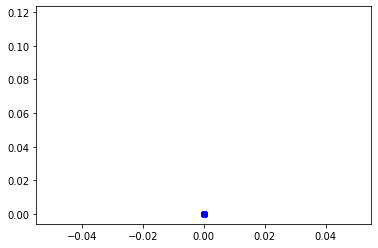

In [0]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, C=np.inf)
clf.coef_ = np.array([[352.95659389, -38.69546198]])
clf.intercept_ = np.array([4.55069124])
clf.classes_ = np.array([0, 1])
draw_scatter(mean_std, clf.predict(mean_std))
mean_coef, std_coef = clf.coef_[0]
bias = clf.intercept_
mean = np.linspace(mean_std[:,0].min(), mean_std[:,0].max())
std = - (mean * mean_coef + bias) / std_coef
plt.plot(mean,std)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class BlurancePredictor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(2,1)
    self.fc.load_state_dict({'weight': torch.Tensor([[352.95659389, -38.69546198]]),
                              'bias': torch. Tensor([4.55069124])})
  def __call__(self, img):
    mean, std = laplace_stats(img)
    x = torch.Tensor([mean, std])
    return F.sigmoid(self.fc(x))

In [0]:
blur_predictor = BlurancePredictor()



In [0]:
import torch
from torchvision import datasets, transforms, models
import os
from PIL import Image
import numpy as np
class TrafficSign(object):
    def __init__(self, root, image_set, transforms):
        if image_set == 'train':
            self.root = os.path.join(root, 'test')
            self.gt_name = os.path.join(root, "gt_train.csv")
        elif image_set == 'val' or image_set == 'test':
            self.root = os.path.join(root, 'test') 
            self.gt_name = os.path.join(root, "gt_test.csv")
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        files_in_dir = os.listdir(self.root)
        self.imgs = sorted(files_in_dir)
        with open(self.gt_name, 'r') as gt_file:
            gt_lines = gt_file.readlines()
        self.ground_truth = self.parse_ground_truth(gt_lines[1:])
    def parse_ground_truth(self, gt_lines):
        class_set = set()
        ground_truth = []
        for entry_line in gt_lines:
            entry_splited = entry_line.split(',')
            img_name = entry_splited[0]
            class_ = int(entry_splited[1])
            if class_ not in class_set:
              class_set.add(class_)
            ground_truth.append(class_)
        self.classes = sorted(list(class_set))
        return ground_truth

    def __getitem__(self, idx):
        # load images ad masks
        img_name = self.imgs[idx]
        img_path = os.path.join(self.root, img_name)
        label = self.ground_truth[idx]
        img = Image.open(img_path).convert("RGB")

        # there is only one class
        label = torch.tensor(label, dtype=torch.int64)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, label

    def __len__(self):
        return len(self.imgs)

In [0]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = 'data/hymenoptera_data'
image_datasets = {x: TrafficSign(data_dir, x, data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

NUM_CLASSES = len(image_datasets['train'].classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
import torch.nn.intrinsic as inn
import torch.quantization as quant
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        # input 3x48x48
        self.quant = quant.QuantStub()
        
        self.conv1 = inn.ConvReLU2d(nn.Conv2d(3, 6, 5), nn.ReLU())
        # 6x44x44
        self.conv2 = inn.ConvReLU2d(nn.Conv2d(6, 6, 3, padding=1, stride=2), nn.ReLU())
        # 6x22x22
        self.conv3 = inn.ConvReLU2d(nn.Conv2d(6, 16, 5), nn.ReLU())
        # 16x18x18
        self.conv4 = inn.ConvReLU2d(nn.Conv2d(16, 16, 3, padding=1, stride=2), nn.ReLU())
        # 16x9x9
        self.flat_features_len = 16 * 9 * 9
        self.fc1 = inn.LinearReLU(nn.Linear(self.flat_features_len, 120), nn.ReLU())
        self.fc2 = inn.LinearReLU(nn.Linear(120, 84), nn.ReLU())
        self.fc3 = nn.Linear(84, num_classes)

        self.dequant = quant.DeQuantStub()

    def forward(self, x):
        x = self.quant(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, self.flat_features_len)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.dequant(x)
        return x


net = Net(NUM_CLASSES)

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cuda')
net = net.to(device)

In [53]:
!git clone https://github.com/pytorch/vision.git

fatal: destination path 'vision' already exists and is not an empty directory.


In [0]:
!cp vision/references/classification/* ./


In [0]:
from train import train_one_epoch, evaluate

In [0]:
train_one_epoch(net, criterion, 
                optimizer, dataloaders['train'], 
                device, 0, 10)

Epoch: [0]  [  0/472]  eta: 1:02:52  lr: 0.001  img/s: 2089.252015815199  loss: 4.2007 (4.2007)  acc1: 0.0000 (0.0000)  acc5: 12.5000 (12.5000)  time: 7.9928  data: 7.9851  max mem: 8
Epoch: [0]  [ 10/472]  eta: 0:25:21  lr: 0.001  img/s: 4657.750138811772  loss: 4.1892 (4.1884)  acc1: 0.0000 (2.2727)  acc5: 18.7500 (17.6136)  time: 3.2927  data: 3.2885  max mem: 8
Epoch: [0]  [ 20/472]  eta: 0:23:15  lr: 0.001  img/s: 3839.838873948618  loss: 4.1847 (4.1859)  acc1: 6.2500 (6.5476)  acc5: 18.7500 (16.6667)  time: 2.8414  data: 2.8375  max mem: 8
Epoch: [0]  [ 30/472]  eta: 0:20:14  lr: 0.001  img/s: 5465.336265168174  loss: 4.1858 (4.1867)  acc1: 6.2500 (6.8548)  acc5: 12.5000 (14.5161)  time: 2.4494  data: 2.4459  max mem: 8
Epoch: [0]  [ 40/472]  eta: 0:19:57  lr: 0.001  img/s: 4059.3312363900313  loss: 4.1837 (4.1846)  acc1: 6.2500 (8.6890)  acc5: 12.5000 (14.7866)  time: 2.4427  data: 2.4394  max mem: 8
Epoch: [0]  [ 50/472]  eta: 0:18:58  lr: 0.001  img/s: 4397.121216092255  loss: